In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spitfire import ChemicalMechanismSpec, Flamelet, build_adiabatic_slfm_library, build_nonadiabatic_defect_transient_slfm_library
from scipy.special import erfinv
from matplotlib import rcParams
import pickle
from mpl_toolkits.mplot3d import Axes3D

rcParams['font.size'] = 12
rcParams['figure.figsize'] = (5,5)


## Function for computing source terms

In [2]:
import spitfire.chemistry.analysis as sca 
from cantera import gas_constant # R [=] J/kmol/K


def get_state_and_src(library):
    mech = library.extra_attributes['mech_spec']
    spec_names = mech.species_names
    
    ### source terms ###
    library = sca.compute_density(mech,library) # density kg/m^3
    library = sca.compute_isobaric_specific_heat(mech,library) # heat capacity cp J/kg/K
    
    ct_sa, lib_shape = sca.get_ct_solution_array(mech, library)

    species_enthalpy = ct_sa.standard_enthalpies_RT * ct_sa.T[:,None] * gas_constant / ct_sa.molecular_weights[None,:] # J/kg
    prod_rates = ct_sa.net_production_rates*ct_sa.molecular_weights # kmol/m^3/s * kg/kmol
    heat_release_rate = -np.sum(prod_rates * species_enthalpy,axis=1) / library['density'].ravel() / library['heat capacity cp'].ravel() # K/s
    Tsrc = np.array([heat_release_rate]).T

    pressure = np.array([library['pressure'].ravel()]).T
    psrc = np.zeros_like(pressure)

    density = np.array([library['density'].ravel()]).T
    Ysrc = prod_rates/density

    library.remove('density')
    library.remove('heat capacity cp')
    
    S_dict = {}
    X_dict = {}
    
    S_dict['T'] = Tsrc.ravel()
    S_dict['P'] = psrc.ravel()
    for ip,p in enumerate(spec_names):
        S_dict[p] = Ysrc[:,ip]
        
#     all_src = np.hstack((Tsrc, psrc, Ysrc))
    
    idx0 = np.where(library.mixture_fraction_grid.ravel()==0.)[0]
    idx1 = np.where(library.mixture_fraction_grid.ravel()==1.)[0]
    
    ### setting source terms to zero at pure streams
    for k in S_dict.keys():
        S_dict[k][idx0] = 0.
        S_dict[k][idx1] = 0.
    ### state variables
        if k=='T':
            X_dict[k] = library['temperature'].ravel()
        elif k=='P':
            X_dict[k] = library['pressure'].ravel()
        else:
            X_dict[k] = library['mass fraction '+k].ravel()
    
    ### extra attributes
    X_dict['mixture_fraction'] = library.mixture_fraction_grid.ravel()
    if 'chi_st' in library.props:
        X_dict['chi_st'] = library['chi_st'].ravel()
    else:
        X_dict['chi_st'] = library.dissipation_rate_stoich_grid.ravel()
    
    return X_dict, S_dict


## Picking fuel/mechanism

In [3]:
mechdir = '/Users/kamilazdybal/GitLab-Multiscale-Utah/ChemicalMechanisms/'
# groupname = 'coh2-hawkes'
# groupname = 'h2-burke'
groupname = 'ethylene-luo'
# groupname = 'methane-gri12'
# groupname = 'methane-gri30'


npts_mixfrac = 161
npts_dissipation = 81
npts_gamma = 61


## Steady states (SLFM)

In [4]:
m = ChemicalMechanismSpec(cantera_xml=mechdir+groupname+'/'+groupname+'.xml',group_name=groupname)

nspec = m.n_species
pressure = 101325.

if groupname=='coh2-hawkes':
    dissipation_rates = np.hstack((np.logspace(-3,2,61), np.linspace(110,375,20)))
    comp = 'CO:0.45 H2:0.05 N2:0.5'
elif groupname=='h2-burke':
    dissipation_rates = np.hstack((np.logspace(-3,2,61), np.linspace(110,600,20)))
    comp = 'H2:0.9 N2:0.1'
elif groupname=='ethylene-luo':
    dissipation_rates = np.logspace(-3,2,npts_dissipation)
    comp = 'C2H4:1.'
elif groupname=='methane-gri12':
    dissipation_rates = np.logspace(-3,np.log10(18),npts_dissipation)
    comp = 'CH4:1.'
elif groupname=='methane-gri30':
    dissipation_rates = np.logspace(-3,np.log10(18),npts_dissipation)
    comp = 'CH4:1.'

    
air = m.stream(stp_air=True)
air.TP = 300., pressure
fuel = m.stream('TPX', (300., pressure, comp))

z_st = m.stoich_mixture_fraction(fuel,air)
print('Zstoich:',z_st)

flamelet_specs = {'mech_spec': m,
                  'oxy_stream': air,
                  'fuel_stream': fuel,
                  'grid_points': npts_mixfrac,
                  'grid_type': 'clustered',
                  'grid_cluster_intensity': 4,
                  'initial_condition': 'equilibrium',
                  'include_enthalpy_flux': False,
                  'include_variable_cp': False}

slfm_lib = build_adiabatic_slfm_library(flamelet_specs,
                                    diss_rate_values=dissipation_rates,
                                    diss_rate_ref='stoichiometric',
                                    verbose=True)

print(slfm_lib)




**** WARNING ****
For species CH2CHO, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  26.0651
	Value computed using high-temperature polynomial: 11.7479


**** WARNING ****
For species CH2CHO, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  13.2934
	Value computed using high-temperature polynomial: 9.71415


**** WARNING ****
For species CH2CHO, discontinuity in s/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  47.9078
	Value computed using high-temperature polynomial: 43.1354
Zstoich: 0.06399687481976629
----------------------------------------------------------------------------------
building adiabatic SLFM library
----------------------------------------------------------------------------------
- mechanism: /Users/kamilazdybal/GitLab-Multiscale-Utah/ChemicalMechanisms/ethylene-luo/ethylene-luo.xml
- 32 species, 206 reactions
- stoichiometric mixture frac

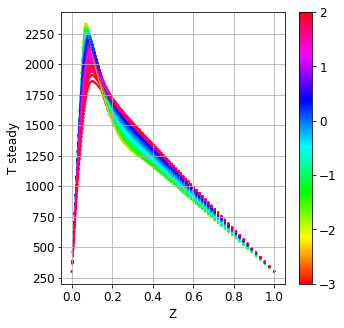

In [5]:
plt.scatter(slfm_lib.mixture_fraction_grid.ravel(), 
            slfm_lib['temperature'].ravel(),
            c=np.log10(slfm_lib.dissipation_rate_stoich_grid.ravel()),
            s=1,
           cmap='hsv')
plt.colorbar()
plt.xlabel('Z')
plt.ylabel('T steady')
plt.grid()
plt.show()


## Transient states

In [6]:
flamelet_specs['stoich_dissipation_rate'] = 1.2*slfm_lib.dissipation_rate_stoich_values[-1]
flamelet_specs['library_slice'] = slfm_lib[:,-1]
f = Flamelet(**flamelet_specs)
tlfm_lib = f.integrate_to_steady(write_log=False, log_rate=30)
chi_max_t = flamelet_specs['stoich_dissipation_rate']*np.exp(2*erfinv(2*z_st-1)**2)
tlfm_lib['chi_max'] = chi_max_t*np.ones_like(tlfm_lib.mixture_fraction_grid)
tlfm_lib['chi_st'] = flamelet_specs['stoich_dissipation_rate']*np.ones_like(tlfm_lib.mixture_fraction_grid)

### remove the first entry on transient library so do not have duplicate states with steady library above
print('last time value before slicing library',tlfm_lib.time_values[-1], tlfm_lib.time_npts)
if groupname=='h2-burke':
    tlfm_lib = tlfm_lib[23::4,:]
elif groupname=='coh2-hawkes':
    tlfm_lib = tlfm_lib[21::4,:]
else:
    tlfm_lib = tlfm_lib[26::4,:]

print('last time value after  slicing library',tlfm_lib.time_values[-1], tlfm_lib.time_npts)
print(tlfm_lib)


last time value before slicing library 0.0049086351426385075 900
last time value after  slicing library 0.0046580894174535585 219

Spitfire Library with 2 dimensions and 36 properties
------------------------------------------
1. Dimension "time" spanning [9.00473507411045e-06, 0.0046580894174535585] with 219 points
2. Dimension "mixture_fraction" spanning [0.0, 1.0] with 161 points
------------------------------------------
temperature         , min = 300.0 max = 1839.2448891434894
pressure            , min = 101324.99999999994 max = 101324.99999999994
mass fraction N2    , min = 0.0 max = 0.7660379936142239
mass fraction H2    , min = 0.0 max = 0.0049900187922065145
mass fraction H     , min = 0.0 max = 0.0002814247823516194
mass fraction O     , min = 0.0 max = 0.0017584324803287998
mass fraction O2    , min = 0.0 max = 0.23396200638577616
mass fraction OH    , min = 0.0 max = 0.0023703213484767005
mass fraction H2O   , min = 0.0 max = 0.07967319233192487
mass fraction HO2   , min =

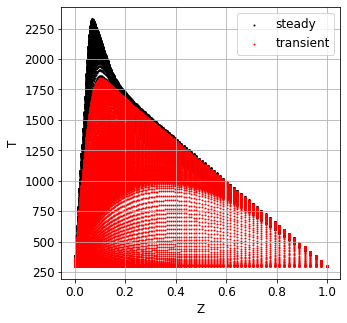

In [7]:
plt.scatter(slfm_lib.mixture_fraction_grid.ravel(), 
            slfm_lib['temperature'].ravel(),
            c='k',s=1,label='steady')
plt.scatter(tlfm_lib.mixture_fraction_grid.ravel(), 
            tlfm_lib['temperature'].ravel(),
            c='r',s=1,label='transient')
plt.xlabel('Z')
plt.ylabel('T')
plt.grid()
plt.legend()
plt.show()


## Nonadiabatic states

In [8]:
flamelet_specs = {'mech_spec': m,
                  'oxy_stream': air,
                  'fuel_stream': fuel,
                  'grid_points': npts_mixfrac,
                  'grid_type': 'clustered',
                  'grid_cluster_intensity': 4,
                  'initial_condition': 'equilibrium',
                  'include_enthalpy_flux': False,
                  'include_variable_cp': False}
nonad_lib = build_nonadiabatic_defect_transient_slfm_library(flamelet_specs=flamelet_specs,
                                                            diss_rate_ref='stoichiometric',
                                                            diss_rate_values=dissipation_rates,
                                                            n_defect_st=npts_gamma,
                                                            verbose=True,
                                                            solver_verbose=False,
#                                                             num_procs=4,
                                                            integration_args={'log_rate':10,'maximum_steps_per_jacobian':10}
                                                            )
# remove steady
nonad_lib = nonad_lib[:,:,1:]
print(nonad_lib)


----------------------------------------------------------------------------------
building nonadiabatic (defect) SLFM library
----------------------------------------------------------------------------------
- mechanism: /Users/kamilazdybal/GitLab-Multiscale-Utah/ChemicalMechanisms/ethylene-luo/ethylene-luo.xml
- 32 species, 206 reactions
- stoichiometric mixture fraction: 0.064
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
building adiabatic SLFM library
----------------------------------------------------------------------------------
- mechanism: /Users/kamilazdybal/GitLab-Multiscale-Utah/ChemicalMechanisms/ethylene-luo/ethylene-luo.xml
- 32 species, 206 reactions
- stoichiometric mixture fraction: 0.064
----------------------------------------------------------------------------------
   1/  81 (chi_stoich =  1.0e-03 1/s)  converged in   2.81 s, T_max = 2325.9
 

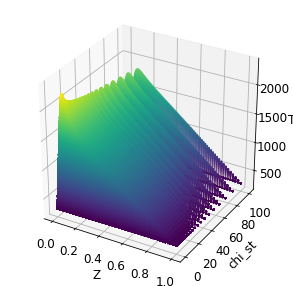

In [9]:
# %matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(nonad_lib.mixture_fraction_grid.ravel(), 
            nonad_lib.dissipation_rate_stoich_grid.ravel(), 
            nonad_lib['temperature'].ravel(),
            c=nonad_lib['temperature'].ravel(),
            s=1)
ax.set_xlabel('Z')
ax.set_ylabel('chi_st')
ax.set_zlabel('T')
plt.grid()
plt.show()


chi_st: 0.001


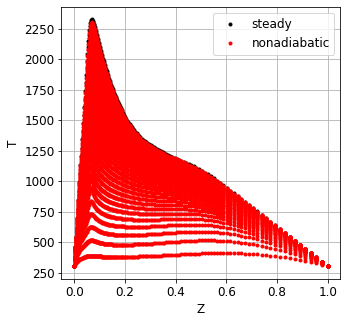

chi_st: 0.31622776601683794


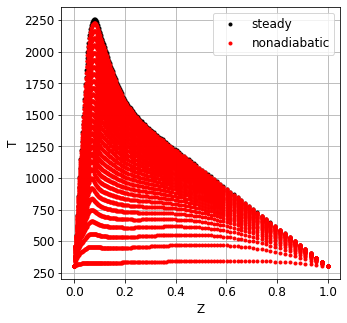

chi_st: 100.0


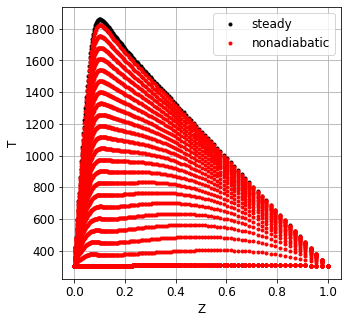

In [10]:
for i in range(0,nonad_lib.dissipation_rate_stoich_npts,40):
    print('chi_st:',nonad_lib.dissipation_rate_stoich_values[i])
    plt.plot(slfm_lib.mixture_fraction_grid[:,i].ravel(), slfm_lib['temperature'][:,i].ravel(),'k.',label='steady')
    plt.plot(nonad_lib.mixture_fraction_grid[:,i,::2].ravel(), nonad_lib['temperature'][:,i,::2].ravel(),'r.', label='nonadiabatic')
    plt.grid()
    plt.xlabel('Z')
    plt.ylabel('T')
    plt.legend()
    plt.show()


## Computing state and source term data

In [11]:
X_steady, SX_steady = get_state_and_src(slfm_lib)
print(X_steady.keys())

X_transient, SX_transient = get_state_and_src(tlfm_lib)
print(X_transient.keys())

X_nonadiabatic, SX_nonadiabatic = get_state_and_src(nonad_lib)
print(X_nonadiabatic.keys())


dict_keys(['T', 'P', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'CH', 'CH2', 'CH2*', 'CH3', 'CH4', 'CO', 'CO2', 'HCO', 'CH2O', 'CH3O', 'C2H2', 'H2CC', 'C2H3', 'C2H4', 'C2H5', 'C2H6', 'HCCO', 'CH2CO', 'CH2CHO', 'CH3CHO', 'aC3H5', 'C3H6', 'nC3H7', 'N2', 'mixture_fraction', 'chi_st'])
dict_keys(['T', 'P', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'CH', 'CH2', 'CH2*', 'CH3', 'CH4', 'CO', 'CO2', 'HCO', 'CH2O', 'CH3O', 'C2H2', 'H2CC', 'C2H3', 'C2H4', 'C2H5', 'C2H6', 'HCCO', 'CH2CO', 'CH2CHO', 'CH3CHO', 'aC3H5', 'C3H6', 'nC3H7', 'N2', 'mixture_fraction', 'chi_st'])
dict_keys(['T', 'P', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'CH', 'CH2', 'CH2*', 'CH3', 'CH4', 'CO', 'CO2', 'HCO', 'CH2O', 'CH3O', 'C2H2', 'H2CC', 'C2H3', 'C2H4', 'C2H5', 'C2H6', 'HCCO', 'CH2CO', 'CH2CHO', 'CH3CHO', 'aC3H5', 'C3H6', 'nC3H7', 'N2', 'mixture_fraction', 'chi_st'])


## Concatenating datasets

In [12]:
include_transient = True
include_nonadiabatic = True

varsDict = {}
srcDict = {}

for k in X_steady.keys():
    if include_transient and not include_nonadiabatic:
        saveprefix = 'transient'
        varsDict[k] = np.hstack((X_steady[k], X_transient[k]))
    elif include_nonadiabatic:
        saveprefix = 'nonadiabatic'
        varsDict[k] = np.hstack((X_steady[k], X_transient[k],  X_nonadiabatic[k]))
    else:
        saveprefix = 'steady'
        varsDict[k] = X_steady[k]

for k in SX_steady.keys():
    if include_transient and not include_nonadiabatic:
        srcDict[k] = np.hstack((SX_steady[k], SX_transient[k]))
    elif include_nonadiabatic:
        srcDict[k] = np.hstack((SX_steady[k], SX_transient[k],  SX_nonadiabatic[k]))
    else:
        srcDict[k] = SX_steady[k]

print(varsDict['mixture_fraction'].size)
print(srcDict['T'].size)


830760
830760


## Checking mass fraction source terms sum to 0 and mass fractions sum to 1

In [13]:
sumsrc = np.zeros_like(srcDict['T'])
sumsp = np.zeros_like(varsDict['T'])

for k in list(srcDict.keys())[2:]:
    sumsrc+= srcDict[k]
    sumsp+= varsDict[k]

print('min and max sum of Ysrc',np.min(sumsrc),np.max(sumsrc))
print('min and max sum of Y',np.min(sumsp),np.max(sumsp))

# plt.plot(varsDict['mixture_fraction'], sumsrc, 'k.')
# # plt.plot(varsDict['mixture_fraction'], sumsp, 'k.')
# plt.show()


min and max sum of Ysrc -5.8210230444778875e-12 4.071866788931853e-12
min and max sum of Y 0.9999999999999991 1.0000000000000009


## Plotting data

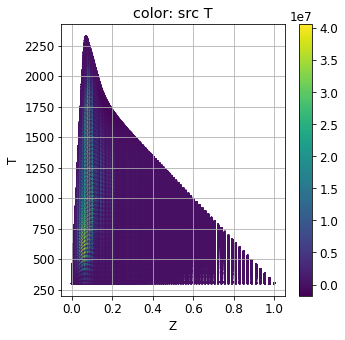

In [14]:
plotvar = 'T'
plt.scatter(varsDict['mixture_fraction'], varsDict[plotvar], c=srcDict[plotvar],s=1)
plt.colorbar()
plt.grid()
plt.xlabel('Z')
plt.ylabel(plotvar)
plt.title('color: src '+plotvar)
plt.show()


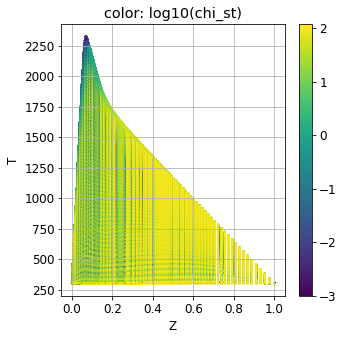

In [15]:
plotvar = 'T'
plt.scatter(varsDict['mixture_fraction'], varsDict[plotvar], c=np.log10(varsDict['chi_st']),s=1)
plt.colorbar()
plt.grid()
plt.xlabel('Z')
plt.ylabel(plotvar)
plt.title('color: log10(chi_st)')
plt.show()


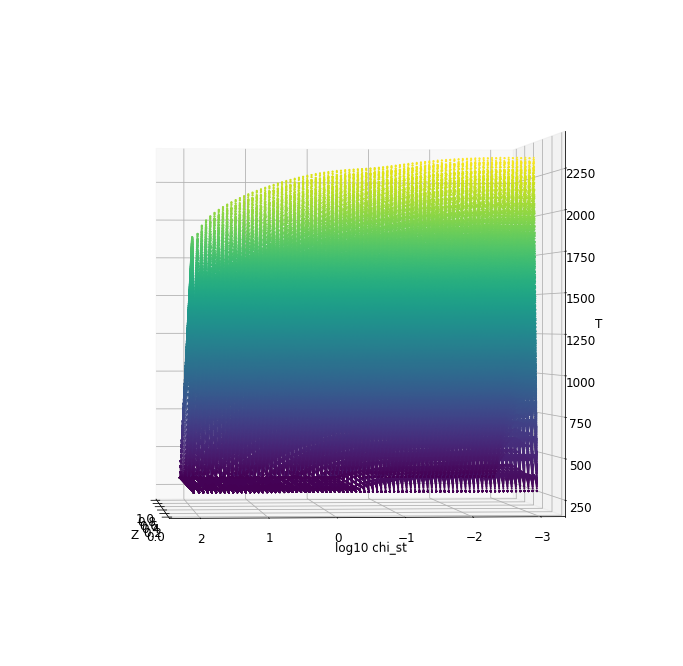

In [16]:
rcParams['figure.figsize'] = (12,12)

if include_nonadiabatic:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(varsDict['mixture_fraction'][::2], 
               np.log10(varsDict['chi_st'][::2]), 
               varsDict['T'][::2],
               c=varsDict['T'][::2],
                s=1)
    ax.set_xlabel('Z')
    ax.set_ylabel('log10 chi_st')
    ax.set_zlabel('T')
    plt.grid()
    ax.view_init(0,175)
    plt.show()
    
rcParams['figure.figsize'] = (5,5)


## Saving data

In [17]:
resave = True

filename = saveprefix+'-'+groupname
print('save prefix:',filename)
if resave:
    pickle.dump(varsDict, open(filename+'-flamelet-state.p','wb'))
    pickle.dump(srcDict, open(filename+'-flamelet-source.p','wb'))
    print('saved')


save prefix: nonadiabatic-ethylene-luo
saved
